#### Import Libraries

In [2]:
from keplergl import KeplerGl
import polars as pl
import matplotlib.pyplot as plt
from src import clean_data
import geohash2

# Enable autoreload extension and set autoreload mode to automatically reload all modules
%load_ext autoreload
%autoreload 2

#### Download data

In [29]:
jan_trip_path = './data/yellow_tripdata_2016-01.csv'

#### Clean Data in Jan, Feb, Mar

Test with Jan 2016 data first

In [30]:
df_jan = pl.read_csv(jan_trip_path, try_parse_dates=True)

In [ ]:
# check shape of data
print(f'Jan 2016 observation: {df_jan.shape[0]:,} rows')

Jan 2016 observation: 10,906,858 rows
Feb 2016 observation: 11,382,049 rows
Mar 2016 observation: 12,210,952 rows


In [22]:
# keep priority columns
priority_columns = ["tpep_pickup_datetime",
                    "pickup_longitude",
                    "pickup_latitude",
                    ]
df_jan = df_jan.select(priority_columns)

In [23]:
# inspect schema
print(df_jan.schema)

Schema([('tpep_pickup_datetime', Datetime(time_unit='us', time_zone=None)), ('pickup_longitude', Float64), ('pickup_latitude', Float64)])
Schema([('tpep_pickup_datetime', Datetime(time_unit='us', time_zone=None)), ('pickup_longitude', Float64), ('pickup_latitude', Float64)])
Schema([('tpep_pickup_datetime', Datetime(time_unit='us', time_zone=None)), ('pickup_longitude', Float64), ('pickup_latitude', Float64)])


Remove nulls and outside of NYC

In [24]:
# Note that we have 170,212 entries in Jan data with 0.0, 0.0 that points to null island
df_jan.filter((pl.col('pickup_longitude')==0.0) & (pl.col('pickup_latitude')==0.0))

tpep_pickup_datetime,pickup_longitude,pickup_latitude
datetime[μs],f64,f64
2016-01-01 00:00:19,0.0,0.0
2016-01-01 00:00:41,0.0,0.0
2016-01-01 00:01:34,0.0,0.0
2016-01-01 00:01:36,0.0,0.0
2016-01-01 00:01:37,0.0,0.0
…,…,…
2016-01-29 09:32:28,0.0,0.0
2016-01-29 09:32:48,0.0,0.0
2016-01-29 09:33:58,0.0,0.0


In [25]:
# Remove `null island` rows
df_jan = df_jan.filter((pl.col('pickup_longitude')!=0.0) & (pl.col('pickup_latitude')!=0.0))

In [27]:
# Set bounding box for NYC (reference:https://en.wikipedia.org/wiki/Module:Location_map/data/USA_New_York_City)
nyc_top = 45.01550900568005
nyc_bottom = 40.502009391283906
nyc_left = -79.7633786294863
nyc_right = -71.85616396303963

df_jan = df_jan.filter(
    ~(
        (pl.col("pickup_latitude") < nyc_bottom) |
        (pl.col("pickup_latitude") > nyc_top) |
        (pl.col("pickup_longitude") < nyc_left) |
        (pl.col("pickup_longitude") > nyc_right)
    )
)


In [29]:
df_jan

tpep_pickup_datetime,pickup_longitude,pickup_latitude
datetime[μs],f64,f64
2016-01-01 00:00:00,-73.990372,40.734695
2016-01-01 00:00:00,-73.980782,40.729912
2016-01-01 00:00:00,-73.98455,40.679565
2016-01-01 00:00:00,-73.993469,40.71899
2016-01-01 00:00:00,-73.960625,40.78133
…,…,…
2016-01-31 23:30:32,-74.003578,40.751011
2016-01-05 00:15:55,-73.945488,40.75153
2016-01-05 06:12:46,-73.99424,40.766586


Downsample to hourly intervals, and aggregate by datetime, location

In [30]:
# sort `tpep_pickup_datetime` in ascending order
df_jan = df_jan.sort('tpep_pickup_datetime')


In [31]:
# set precision of `pickup_longitude` & `pickup_latitude` to 3 dp (neighbourhood/streets)
df_jan = df_jan.with_columns(
    pl.col("pickup_longitude").round(3),
    pl.col("pickup_latitude").round(3),
)

In [32]:
# downsample to 1 hour and agg count of pickups by location, & hour. 
df_jan = df_jan.group_by_dynamic("tpep_pickup_datetime", every="1h", group_by=["pickup_longitude", "pickup_latitude"]).agg(pl.len().alias("current_pickup_count"))

In [33]:
# Checking categories of downsampled datetime, to identify missing entries
# 24 hours * 31 days = 744, so we have all hours in Jan 2016 data
hourly_value_counts = df_jan.select([
    pl.col("tpep_pickup_datetime").value_counts()
])

print(hourly_value_counts.shape[0])

744


In [34]:
df_jan

pickup_longitude,pickup_latitude,tpep_pickup_datetime,current_pickup_count
f64,f64,datetime[μs],u32
-73.99,40.735,2016-01-01 00:00:00,18
-73.99,40.735,2016-01-01 01:00:00,24
-73.99,40.735,2016-01-01 02:00:00,29
-73.99,40.735,2016-01-01 03:00:00,19
-73.99,40.735,2016-01-01 04:00:00,15
…,…,…,…
-73.902,40.867,2016-01-31 22:00:00,1
-73.586,40.716,2016-01-31 23:00:00,1
-73.87,40.662,2016-01-31 23:00:00,1


Now we repeat the same cleaning process for Feb and Mar 2016 data

In [106]:
# define path
feb_trip_path = './data/yellow_tripdata_2016-02.csv'
mar_trip_path = './data/yellow_tripdata_2016-03.csv'

In [107]:
# load data into polars DataFrame
df_feb = pl.read_csv(feb_trip_path, try_parse_dates=True)
df_mar = pl.read_csv(mar_trip_path, try_parse_dates=True)

In [108]:
# Inspect schema for Feb 2016 and Mar 2016
print(df_feb.schema)
print(df_mar.schema)

Schema([('VendorID', Int64), ('tpep_pickup_datetime', Datetime(time_unit='us', time_zone=None)), ('tpep_dropoff_datetime', Datetime(time_unit='us', time_zone=None)), ('passenger_count', Int64), ('trip_distance', Float64), ('pickup_longitude', Float64), ('pickup_latitude', Float64), ('RatecodeID', Int64), ('store_and_fwd_flag', String), ('dropoff_longitude', Float64), ('dropoff_latitude', Float64), ('payment_type', Int64), ('fare_amount', Float64), ('extra', Float64), ('mta_tax', Float64), ('tip_amount', Float64), ('tolls_amount', Float64), ('improvement_surcharge', Float64), ('total_amount', Float64)])
Schema([('VendorID', Int64), ('tpep_pickup_datetime', Datetime(time_unit='us', time_zone=None)), ('tpep_dropoff_datetime', Datetime(time_unit='us', time_zone=None)), ('passenger_count', Int64), ('trip_distance', Float64), ('pickup_longitude', Float64), ('pickup_latitude', Float64), ('RatecodeID', Int64), ('store_and_fwd_flag', String), ('dropoff_longitude', Float64), ('dropoff_latitude',

In [109]:
# Instantiate cleaning pipeline for feb and mar data
clean_feb = clean_data.CleanData(df=df_feb,
                                 cols_to_keep=priority_columns,
                                 pickup_datetime_col='tpep_pickup_datetime'
                                )

clean_mar = clean_data.CleanData(df=df_mar,
                                 cols_to_keep=priority_columns,
                                 pickup_datetime_col='tpep_pickup_datetime'
                                )

In [ ]:
# Clean feb 2016 data
df_feb = clean_feb.clean_pipeline()

2025-01-13 14:59:12,283 - INFO - select_columns - df shape after keeping priority cols: (11382049, 3)
2025-01-13 14:59:12,307 - INFO - remove_null_island - df shape after removing nulls: (11205215, 3)
2025-01-13 14:59:12,308 - INFO - remove_null_island - removed 176834 null island rows
2025-01-13 14:59:12,320 - INFO - remove_outside_ny - df shape after keeping priority cols: (11204861, 3)
2025-01-13 14:59:12,320 - INFO - remove_outside_ny - Removed 354 rows outside New York
2025-01-13 14:59:12,320 - INFO - downsample_1h - Downsampling into 1h intervals and aggregating hourly pickup count by location
2025-01-13 14:59:12,964 - INFO - clean_pipeline - Cleaning completed, current shape of df: (1865730, 4)


In [113]:
# Clean mar 2016 data
df_mar = clean_mar.clean_pipeline() 

2025-01-13 15:09:25,221 - INFO - select_columns - df shape after keeping priority cols: (12210952, 3)


2025-01-13 15:09:25,271 - INFO - remove_null_island - df shape after removing nulls: (12028951, 3)
2025-01-13 15:09:25,272 - INFO - remove_null_island - removed 182001 null island rows
2025-01-13 15:09:25,285 - INFO - remove_outside_ny - df shape after keeping priority cols: (12028542, 3)
2025-01-13 15:09:25,286 - INFO - remove_outside_ny - Removed 409 rows outside New York
2025-01-13 15:09:25,286 - INFO - downsample_1h - Downsampling into 1h intervals and aggregating hourly pickup count by location
2025-01-13 15:09:26,066 - INFO - clean_pipeline - Cleaning completed, current shape of df: (2008811, 4)


Check unique values of hourly timestamps in Feb and Mar 2016

In [114]:
# 29 days * 24 hours = 696
# There are 696 hourly intervals for month of Feb 2016
hourly_value_counts = df_feb.select([
    pl.col("tpep_pickup_datetime").value_counts()
])

print(hourly_value_counts.shape[0])

696


In [116]:
# 29 days * 24 hours = 696
# There are 696 hourly intervals for month of Feb 2016
hourly_value_counts = df_mar.select([
    pl.col("tpep_pickup_datetime").value_counts()
])

print(hourly_value_counts.shape[0])

744


Concatenate jan, feb and mar together 

In [117]:
# Concatenate datasets 
df = pl.concat(
    [df_jan, df_feb, df_mar]
)

In [122]:
# Inspect shape
print(f'Combined cleaned dataset has: {df.shape[0]:,} rows')
print(f'Combined cleaned dataset has: {df.shape[1]} cols')

Combined cleaned dataset has: 5,748,431 rows
Combined cleaned dataset has: 4 cols


In [123]:
# Save data to ./data folder
path = "./data/combined_cleaned_dataset.csv"
df.write_csv(path, separator=",")

#### EDA

Load data

In [3]:
path = './data/combined_cleaned_dataset.csv'
df = pl.read_csv(path, try_parse_dates=True)

In [18]:
df.head()

pickup_longitude,pickup_latitude,tpep_pickup_datetime,current_pickup_count
f64,f64,datetime[μs],i64
-73.99,40.735,2016-01-01 00:00:00,18
-73.99,40.735,2016-01-01 01:00:00,24
-73.99,40.735,2016-01-01 02:00:00,29
-73.99,40.735,2016-01-01 03:00:00,19
-73.99,40.735,2016-01-01 04:00:00,15


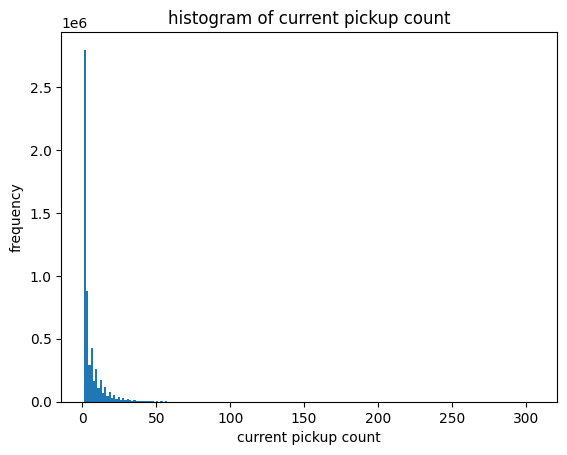

In [19]:
plt.hist(df['current_pickup_count'], bins=200)
 
# Adding labels and title
plt.xlabel('current pickup count')
plt.ylabel('frequency')
plt.title('histogram of current pickup count')
 
# Display the plot
plt.show()

#### Feature Engineering

Create a column `is_weekend` which is either 1 or 0 if `tpep_pickup_datetime` is weekend

In [4]:
df = df.with_columns(
    pl.when(pl.col("tpep_pickup_datetime").dt.weekday()==6)
    .then(1)
    .when(pl.col("tpep_pickup_datetime").dt.weekday()==7)
    .then(1)
    .otherwise(0)
    .alias("is_weekend")
)

Create a column `day_of_week` which varies from 1 to 7 

In [5]:
df = df.with_columns(
    pl.col("tpep_pickup_datetime").dt.weekday().alias("day_of_week")
)

Create a column `hour_of_day` 

In [6]:
df = df.with_columns(
    pl.col("tpep_pickup_datetime").dt.hour().alias("hour_of_day")
)

In [7]:
df.sample(n=10, seed=42)

pickup_longitude,pickup_latitude,tpep_pickup_datetime,current_pickup_count,is_weekend,day_of_week,hour_of_day
f64,f64,datetime[μs],i64,i32,i8,i8
-73.985,40.756,2016-01-17 04:00:00,12,1,7,4
-73.955,40.79,2016-01-15 16:00:00,1,0,5,16
-73.998,40.761,2016-03-10 01:00:00,4,0,4,1
-73.964,40.783,2016-01-19 19:00:00,1,0,2,19
-73.952,40.824,2016-02-28 22:00:00,1,1,7,22
-74.015,40.715,2016-01-21 11:00:00,4,0,4,11
-74.007,40.717,2016-01-05 14:00:00,1,0,2,14
-74.001,40.756,2016-01-09 15:00:00,5,1,6,15
-74.009,40.739,2016-03-25 11:00:00,6,0,5,11


Incorporate Weather information by creating temperature and precipitation columns

In `src/query_weather.py`, I used 40.7128° N, 74.0060° W as New York location to query the hourly weather for New York, generate the dataset `data/ny_weather_dataset.csv`

In [8]:
filepath = "./data/ny_weather_dataset.csv"
weather_data = pl.read_csv(filepath, try_parse_dates=True)

In [9]:
# select temperature, precipitation (rainfall) and snow
weather_data = weather_data.select(
    pl.col("time"),
    pl.col("temp"),
    pl.col("prcp"),
)

In [10]:
# Inspect nulls for precipitation
pl.Config(tbl_rows=50)
weather_data.filter(pl.col("prcp").is_null())

time,temp,prcp
datetime[μs],f64,f64
2016-01-01 00:00:00,7.2,null
2016-01-10 06:00:00,8.9,null
2016-01-10 07:00:00,8.9,null
2016-01-12 22:00:00,2.0,null
2016-01-14 11:00:00,-5.0,null
2016-01-14 12:00:00,-5.0,null
2016-01-16 06:00:00,6.7,null
2016-01-17 20:00:00,1.1,null
2016-01-18 01:00:00,-0.6,null


In [11]:
# Since nulls are only for short sporadic periods, we can use front fill and back fill strategy

weather_data = weather_data.with_columns(
    pl.col("prcp").fill_null(strategy="forward")
)
weather_data = weather_data.with_columns(
    pl.col("prcp").fill_null(strategy="backward")
)


In [12]:
# Save the cleaned weather data set into ./data
filepath = "./data/ny_weather_dataset_cleaned.csv"
weather_data.write_csv(filepath, separator=",")

In [13]:
# Join df and weather
df = df.join(weather_data,
        how='left',
        left_on='tpep_pickup_datetime',
        right_on='time',
        coalesce=True      
)

Encode geohash with `pickup_geohash` column

In [14]:
def encode_geohash(lat_lon_dict: dict, precision: int = 7) -> str:
    lat, lon = float(lat_lon_dict["pickup_latitude"]), float(lat_lon_dict["pickup_longitude"])
    return geohash2.encode(lat, lon, precision=precision)

df = df.with_columns(
    pl.struct(["pickup_latitude", "pickup_longitude"]).
    map_elements(encode_geohash, return_dtype=pl.String).
    alias("pickup_geohash")
)

Create target variable `target_pickup_count`, which is the next hour's pickup_count

In [15]:
# Create a leading variable and remove the last null row
df = df.with_columns(
    pl.col("current_pickup_count").shift(-1).\
        over(["pickup_latitude","pickup_longitude"], order_by="tpep_pickup_datetime").\
        alias("target_pickup_count")
)


In [16]:
# remove null rows
df = df.filter(df["target_pickup_count"].is_not_null())

Create `month` column

In [21]:
df = df.with_columns(
    pl.col("tpep_pickup_datetime").dt.month().alias("month")
)

Create `day_of_month` column

In [23]:
df = df.with_columns(
    pl.col("tpep_pickup_datetime").dt.day().alias("day_of_month")
)

In [26]:
# save df to dataset
filepath = "./data/feature_engineered_dataset.csv"
df.write_csv(filepath, separator=",")